# 3) POS Pattern Frequency (Adj+N, V+N, etc.)

This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

Overview:
- Analyze grammatical patterns in bigrams using Part-of-Speech (POS) tagging.
- Identify common POS patterns like ADJ+NOUN, VERB+NOUN, NOUN+NOUN across two works by the same author.
- Visualize the distribution of POS patterns to understand syntactic phrase structure.

Learning objectives:
- Apply spaCy POS tagging to tokenized text for grammatical analysis.
- Compute and compare POS bigram patterns across literary texts.
- Visualize syntactic patterns to identify stylistic features.
- Understand how preprocessing choices (stopwords, filtering) affect syntactic analysis.

Quick start:
1. Edit the `CONFIG` dictionary in the next code cell to point to your two plain-text books.
2. (Optional) Toggle `use_stopwords` to remove common function words.
3. Run cells from top to bottom. The main outputs are saved to `../results/`.
4. Ensure `en_core_web_sm` spaCy model is installed (included in requirements.txt).

Prerequisites:
- A Python environment with requirements.txt packages installed (pandas, matplotlib, spacy).
- spaCy English model: `en_core_web_sm` (should be installed via requirements.txt).
- The text files for the two works placed in `../data/`.

Notes and tips:
- The notebook uses the same robust preprocessing as notebooks 1-2 (strip_gutenberg, normalize quotes, etc.).
- POS tagging can be slow on large texts; consider slicing tokens or processing in chunks.
- Common patterns: ADJ+NOUN (descriptive phrases), VERB+NOUN (action phrases), NOUN+NOUN (compounds).
- Compare patterns between your two books to see if syntactic style differs.
- For non-English texts, change the spaCy model in the CONFIG or POS tagging cell (e.g., `de_core_news_sm` for German).

**Goal:** Identify and visualize the most frequent Part-of-Speech bigram patterns (e.g., ADJ+NOUN, VERB+NOUN) in your two selected works.


## 0. Setup & Configuration

- Fill the `CONFIG` paths for your two books (plain text).
- Toggle stopwords and thresholds as needed.


In [1]:
# ===== Imports & Config =====
import re, os, math, json, collections
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

CONFIG = {
    "book1_path": "../data/PetSemetary.txt",
    "book2_path": "../data/TheShining.txt",
    "language": "en",
    "use_stopwords": True,           # turn on stopwords
    "min_ngram_count": 5,
    "top_k": 20,

    # Personalized: remove names + junk for these two novels
    "extra_stopwords": [
        # Pet Sematary
        "louis", "rachel", "gage", "ellie", "jud", "crandall", "creed",
        # The Shining
        "jack", "wendy", "danny", "hallorann", "ullman", "overlook", "hotel",
        # Generic dialogue words
        "said", "mister", "mrs", "mr"
    ]
}   



## 1. Load & Normalize Text

- Fix hyphenated line breaks (e.g., end-of-line hyphens).
- Normalize whitespace.
- Lowercase consistently.

Our books are a part of Project Gutenberg, which means there are some extra texts in each txt file to be cleaned.

In [2]:
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

# Stopwords (spaCy if available, else fallback)
try:
    import spacy
    from spacy.lang.en.stop_words import STOP_WORDS as _spacy_stop
    STOPWORDS = {w.lower() for w in _spacy_stop}
except Exception:
    STOPWORDS = {
        "the","and","to","of","a","in","it","is","that","i","you","he","she",
        "they","we","was","for","on","with","as","at","by","an"
    }

# Merge extra stopwords from CONFIG (names, etc.)
EXTRA = set(CONFIG.get("extra_stopwords", []))
EXTRA = {x.lower() for x in EXTRA}
STOPWORDS |= EXTRA

In [3]:
def load_text(path: str) -> str:
    """Load a text file as UTF-8, ignoring bad bytes."""
    return Path(path).read_text(encoding="utf-8", errors="ignore")

def normalize_text(t: str) -> str:
    """Simple normalization for local King TXT files (not Gutenberg)."""
    if not t:
        return ""
    # normalize curly apostrophes to ASCII '
    t = t.replace("’", "'").replace("‘", "'")
    # join hyphenated line breaks: "won-\n derful" → "wonderful"
    t = re.sub(r"-\s*\n", "", t)
    # normalize whitespace
    t = re.sub(r"\s+", " ", t)
    return t.strip()

# Load and normalize
text1 = normalize_text(load_text(CONFIG["book1_path"]))  # Pet Sematary
text2 = normalize_text(load_text(CONFIG["book2_path"]))  # The Shining

# Tokenize
tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())

# Apply stopwords if enabled
if CONFIG["use_stopwords"]:
    tokens1 = [t for t in tokens1 if t not in STOPWORDS]
    tokens2 = [t for t in tokens2 if t not in STOPWORDS]

# Optional: prune junk 1–2 letter tokens (same rule as other notebooks)
keep_1 = {"a", "i"}
keep_2 = {
    "of","to","in","on","by","an","or","as","is","it","we","us","he","me","my",
    "so","be","do","no","at","up","if","go","am","oh"
}

tokens1 = [
    t for t in tokens1
    if (len(t) > 2)
       or (len(t) == 1 and t in keep_1)
       or (len(t) == 2 and t in keep_2)
]
tokens2 = [
    t for t in tokens2
    if (len(t) > 2)
       or (len(t) == 1 and t in keep_1)
       or (len(t) == 2 and t in keep_2)
]

tokens = tokens1 + tokens2

print("Token counts after normalization + pruning:")
print("Pet Sematary:", len(tokens1))
print("The Shining :", len(tokens2))
print("Combined    :", len(tokens))


Token counts after normalization + pruning:
Pet Sematary: 59703
The Shining : 67429
Combined    : 127132


## 2. POS Tagging Setup

Uses spaCy. For English: `en_core_web_sm`. For other languages, switch to an appropriate model. `en_core_web_sm` should be downloaded for you if you followed the requirements.txt requirements.


In [4]:
import spacy
from spacy.cli import download as spacy_download

# Ensure model is available
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    spacy_download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

def extract_pos_patterns(token_list, nlp_model):
    """
    Extract POS bigram patterns from a list of tokens.
    Returns Counter of patterns like 'ADJ+NOUN', 'VERB+NOUN', etc.
    """
    # Join tokens to one string; spaCy will re-tokenize but that's fine here
    doc = nlp_model(" ".join(token_list))
    pairs = []
    for i in range(len(doc) - 1):
        a, b = doc[i], doc[i+1]
        if a.is_alpha and b.is_alpha:
            pairs.append(f"{a.pos_}+{b.pos_}")
    return Counter(pairs)

## 3. Visualize Top POS Patterns

### 3.1 Combined Corpus

In [5]:
print("Analyzing combined corpus...")
pat_counts_combined = extract_pos_patterns(tokens, nlp)
pos_df_combined = (
    pd.DataFrame(pat_counts_combined.items(), columns=["pattern", "count"])
      .sort_values("count", ascending=False)
      .head(CONFIG["top_k"])
      .reset_index(drop=True)
)

print("Analyzing Book 1 (Pet Sematary)...")
pat_counts_1 = extract_pos_patterns(tokens1, nlp)
pos_df_1 = (
    pd.DataFrame(pat_counts_1.items(), columns=["pattern", "count"])
      .sort_values("count", ascending=False)
      .head(CONFIG["top_k"])
      .reset_index(drop=True)
)

print("Analyzing Book 2 (The Shining)...")
pat_counts_2 = extract_pos_patterns(tokens2, nlp)
pos_df_2 = (
    pd.DataFrame(pat_counts_2.items(), columns=["pattern", "count"])
      .sort_values("count", ascending=False)
      .head(CONFIG["top_k"])
      .reset_index(drop=True)
)

print("POS analysis complete.\n")
print("Top combined POS patterns:")
display(pos_df_combined)


Analyzing combined corpus...
Analyzing Book 1 (Pet Sematary)...
Analyzing Book 2 (The Shining)...
POS analysis complete.

Top combined POS patterns:


,pattern,count
0,NOUN+NOUN,18780
1,NOUN+VERB,18341
2,VERB+NOUN,15049
3,ADJ+NOUN,11022
4,VERB+ADJ,6447
5,VERB+VERB,5837
6,NOUN+ADJ,4526
7,PROPN+PROPN,3247
8,ADV+VERB,2751
9,VERB+ADV,2639


### 3.2 Per-Book Comparison

Compare POS patterns across the two works to see if syntactic style differs.

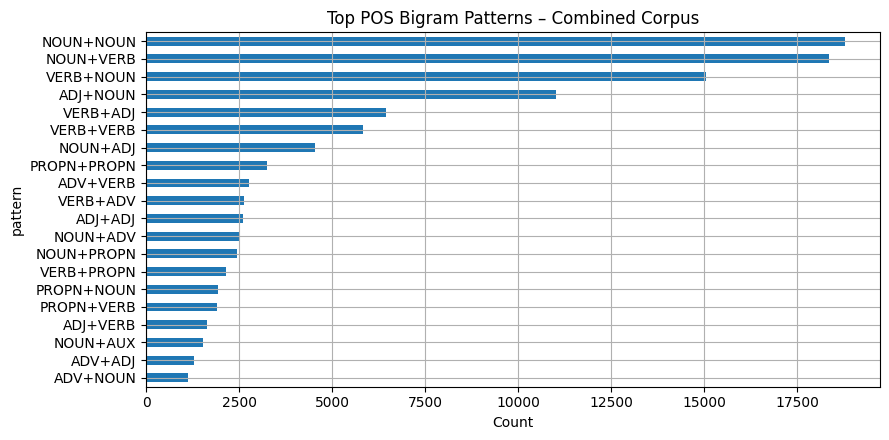

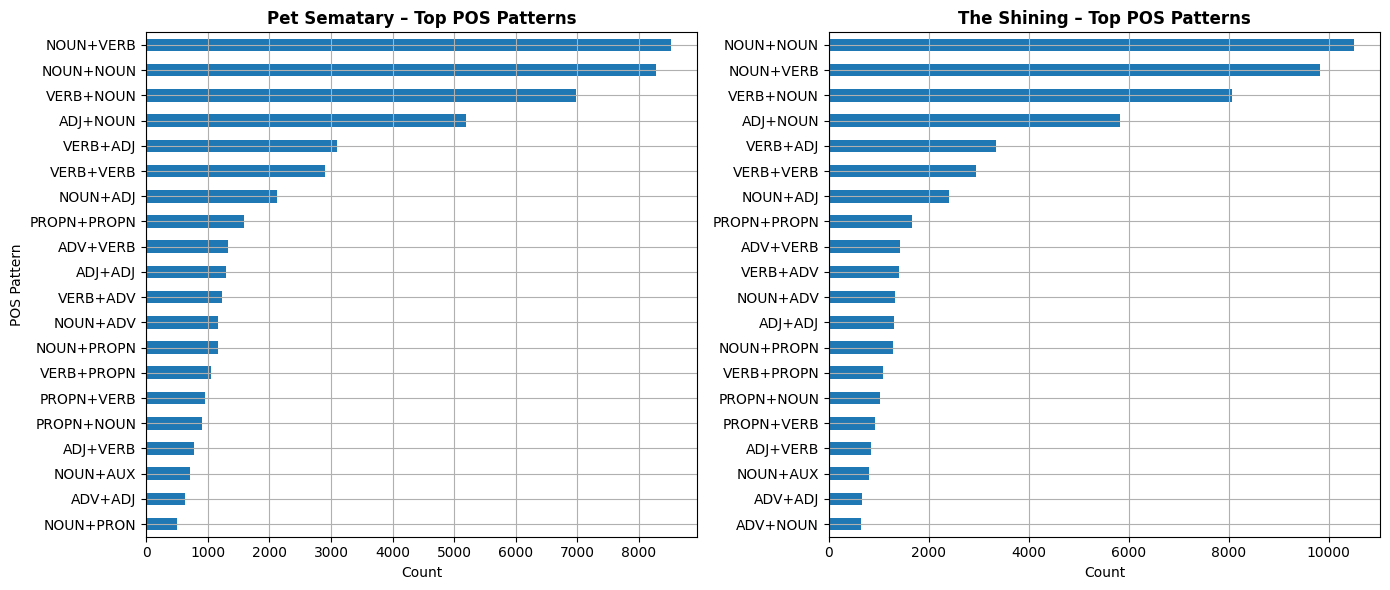

In [6]:
# 5.1 Combined corpus
ax = pos_df_combined.plot.barh(
    x="pattern",
    y="count",
    legend=False
)
ax.invert_yaxis()
ax.set_title("Top POS Bigram Patterns – Combined Corpus")
ax.set_xlabel("Count")
fig_pos_combined = ax.get_figure()
plt.tight_layout()
plt.show()

# 5.2 Per-book comparison
fig_pos_compare, axes = plt.subplots(1, 2, figsize=(14, 6))

# Book 1
ax1 = axes[0]
pos_df_1.plot.barh(
    x="pattern",
    y="count",
    legend=False,
    ax=ax1
)
ax1.invert_yaxis()
ax1.set_title("Pet Sematary – Top POS Patterns", fontsize=12, fontweight="bold")
ax1.set_xlabel("Count")
ax1.set_ylabel("POS Pattern")

# Book 2
ax2 = axes[1]
pos_df_2.plot.barh(
    x="pattern",
    y="count",
    legend=False,
    ax=ax2
)
ax2.invert_yaxis()
ax2.set_title("The Shining – Top POS Patterns", fontsize=12, fontweight="bold")
ax2.set_xlabel("Count")
ax2.set_ylabel("")

plt.tight_layout()
plt.show()


## 4. Notes

- Useful patterns: `ADJ+NOUN`, `NOUN+NOUN`, `VERB+NOUN`, `PRON+VERB`.
- The notebook now analyzes POS patterns for both books individually and for the combined corpus.
- Compare the per-book visualizations to identify syntactic style differences between the two works.

### Interpretation Tips

Comparing POS patterns across works by the same author can reveal:

1. **Stylistic consistency**: If both books show similar POS pattern distributions, the author has a consistent syntactic style across works.

2. **Genre or thematic differences**: Variations in patterns like `ADJ+NOUN` vs. `NOUN+NOUN` may reflect different narrative approaches—more descriptive vs. more action-oriented writing.

3. **Character-driven vs. narration-driven prose**: Higher `PRON+VERB` counts suggest dialogue-heavy or character-focused sections, while `ADJ+NOUN` dominance indicates descriptive narration.

4. **Syntactic complexity**: The diversity and distribution of patterns can indicate sentence structure complexity—varied patterns suggest more sophisticated syntax.

5. **Temporal evolution**: If the books were written at different times, pattern differences may reflect the author's stylistic development or changing literary influences.

For example, if Book 1 shows more `ADJ+NOUN` patterns while Book 2 has more `VERB+NOUN`, this might suggest a shift from descriptive to action-oriented writing style.


## 5. Reflection (Answer in your repo's README or below)

- Which results matched your reading intuition?
- What surprised you?
- If you toggled preprocessing (stopwords on/off), what changed?
- Compare across the two works: are the patterns stable?

## 6. Export (tables/figures)

This cell saves outputs into the `../results/` folder so you can add them to your report.


In [7]:
Path("../results").mkdir(exist_ok=True)

# Save CSV tables
pos_df_combined.to_csv("../results/POS_patterns_combined.csv", index=False)
pos_df_1.to_csv("../results/POS_patterns_book1.csv", index=False)
pos_df_2.to_csv("../results/POS_patterns_book2.csv", index=False)

# Save figures
saved_files = []
try:
    fig_pos_combined.savefig("../results/POS_patterns_combined.png", dpi=200, bbox_inches="tight")
    saved_files.append("POS_patterns_combined.png")
except NameError:
    pass

try:
    fig_pos_compare.savefig("../results/POS_patterns_comparison.png", dpi=200, bbox_inches="tight")
    saved_files.append("POS_patterns_comparison.png")
except NameError:
    pass

if saved_files:
    print("Saved CSV tables and figures to ../results/:")
    print("  - POS_patterns_combined.csv, POS_patterns_book1.csv, POS_patterns_book2.csv")
    print("  - " + ", ".join(saved_files))
else:
    print("Figures not saved – run the visualization cells first.")

Saved CSV tables and figures to ../results/:
  - POS_patterns_combined.csv, POS_patterns_book1.csv, POS_patterns_book2.csv
  - POS_patterns_combined.png, POS_patterns_comparison.png
